In [1]:
from datasets import load_dataset, DatasetDict, Dataset, concatenate_datasets, IterableDataset, load_from_disk
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
import torch
from transformers import WhisperForConditionalGeneration

from dataclasses import dataclass
from typing import Any, Dict, List, Union
import evaluate
from transformers import WhisperProcessor
from transformers import WhisperTokenizer
from transformers import WhisperFeatureExtractor
import pylab as plt
import speech_utils as su

metric = evaluate.load("wer")
chunk_length = 16



/home/kd/Desktop/proj/apr/Punjabi_ASR/speech_utils.py:13: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")
/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/datasets/load.py:759: FutureWarning: The repository for wer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/wer/wer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Loading dataset from disk:   0%|          | 0/67 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/20 [00:00<?, ?it/s]

Dataset summary: 
DatasetDict({
    train: Dataset({
        features: ['audio', 'text', 'duration'],
        num_rows: 167141
    })
    test: Dataset({
        features: ['audio', 'text', 'duration'],
        num_rows: 1486
    })
})
train duration in hours: 289.02
test duration in hours: 3.2
Max duration: 29.346 seconds
Min duration: 0.1380625 seconds
Avg duration: 6.238641506475831 seconds

Max text length: 474 characters
Min text length: 0 characters
Avg text length: 84.01642678811815 characters

Train: 163829 (98.02%) | Removing 3312 samples
Test: 1381 (92.93%) | Removing 105 samples


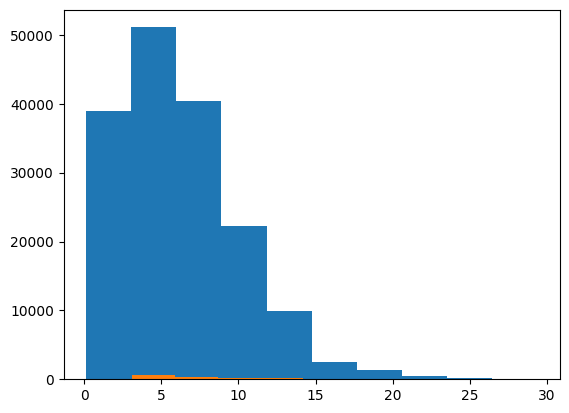

In [2]:
ds = load_from_disk("./datasets/Punjabi_ASR_2")
su.get_summary(ds)

train_durations = ds['train']['duration']
test_durations = ds['test']['duration']

train_indexes = [i for i, duration in enumerate(train_durations) if duration < chunk_length]
test_indexes = [i for i, duration in enumerate(test_durations) if duration < chunk_length]

print(f"Train: {len(train_indexes)} ({len(train_indexes)/len(train_durations)*100:.2f}%) | Removing {len(train_durations) - len(train_indexes)} samples")
print(f"Test: {len(test_indexes)} ({len(test_indexes)/len(test_durations)*100:.2f}%) | Removing {len(test_durations) - len(test_indexes)} samples")

ds = DatasetDict({
    'train': ds['train'].select(train_indexes),
    'test': ds['test'].select(test_indexes)
})


In [3]:
model_name = 'openai/whisper-medium'
feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name, chunk_length=chunk_length)
tokenizer = WhisperTokenizer.from_pretrained(model_name, language="Punjabi", task="transcribe")
processor = WhisperProcessor(feature_extractor=feature_extractor, tokenizer=tokenizer)
model = WhisperForConditionalGeneration.from_pretrained(model_name)

model.generation_config.language = "punjabi"
model.generation_config.task = "transcribe"

model.generation_config.forced_decoder_ids = None

/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
def prepare_dataset(batch):
    audio = batch["audio"]
    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["text"]).input_ids
    return batch


# for testing
# ds = DatasetDict({
#     'train': ds['train'].select(range(1000)),
#     'test': ds['test'].select(range(1000))
# })
ds = ds.map(prepare_dataset, num_proc=1, cache_file_names={'train': "/mnt/sea/temp/train-mid2.arrow", 'test': "/mnt/sea/temp/test-mid22.arrow"})

In [5]:


@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch
    
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [6]:

training_args = Seq2SeqTrainingArguments(
    output_dir="./checkpoints/whisper/whisper-medium-pa",  
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,  
    learning_rate=1e-5,
    num_train_epochs=14,
    warmup_ratio=0.1,
    dataloader_num_workers=4,
    dataloader_prefetch_factor=8,
    # max_steps=4000,
    save_total_limit=4,
    gradient_checkpointing=True,
    bf16=True,
    evaluation_strategy="steps",
    run_name='whisper-medium-pa-1',
    predict_with_generate=True,
    # generation_max_length=225,
    save_steps=300,
    eval_steps=300,
    logging_steps=10,
    report_to=["tensorboard", "wandb"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    # push_to_hub=True,
)
tokenizer.encode("ਹ"), tokenizer.decode([156, 26741])

([50258, 50321, 50359, 50363, 156, 26741, 50257], 'ਹ')

In [7]:
train_labels_lengths = ds['train']['labels']
test_labels_lengths = ds['test']['labels']

train_labels_lengths = [len(i) for i in train_labels_lengths]
test_labels_lengths = [len(i) for i in test_labels_lengths]

train_selected_indexes = [i for i in range(len(train_labels_lengths)) if train_labels_lengths[i] < 446 and train_labels_lengths[i] > 6] # 5 tokens are special tokens added for each sequence
test_selected_indexes = [i for i in range(len(test_labels_lengths)) if test_labels_lengths[i] < 446 and test_labels_lengths[i] > 6]

print(f"Removing {len(ds['train']) - len(train_selected_indexes)} samples from training set")
print(f"Removing {len(ds['test']) - len(test_selected_indexes)} samples from test set")

train_ds = ds['train'].select(train_selected_indexes)
test_ds = ds['test'].select(test_selected_indexes)

ds = DatasetDict({"train": train_ds, "test": test_ds})
print(ds)

Removing 471 samples from training set
Removing 4 samples from test set
DatasetDict({
    train: Dataset({
        features: ['audio', 'text', 'duration', 'input_features', 'labels'],
        num_rows: 163358
    })
    test: Dataset({
        features: ['audio', 'text', 'duration', 'input_features', 'labels'],
        num_rows: 1377
    })
})


In [8]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=ds['train'],
    eval_dataset=ds['test'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [9]:
processor.save_pretrained(training_args.output_dir)

[]

In [10]:
trainer.train(resume_from_checkpoint='/home/kd/Desktop/proj/apr/Punjabi_ASR/checkpoints/whisper/whisper-medium-pa/checkpoint-19800')

There were missing keys in the checkpoint model loaded: ['proj_out.weight'].
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kdcyberdude. Use `wandb login --relogin` to force relogin


  0%|          | 0/71470 [00:00<?, ?it/s]

/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


{'loss': 0.0119, 'grad_norm': 0.38743630051612854, 'learning_rate': 8.031341821743389e-06, 'epoch': 3.88}
{'loss': 0.0122, 'grad_norm': 0.4175557792186737, 'learning_rate': 8.029787167887072e-06, 'epoch': 3.88}
{'loss': 0.0113, 'grad_norm': 0.46016931533813477, 'learning_rate': 8.028232514030751e-06, 'epoch': 3.88}
{'loss': 0.0115, 'grad_norm': 0.3341807425022125, 'learning_rate': 8.026677860174434e-06, 'epoch': 3.89}
{'loss': 0.0129, 'grad_norm': 0.48281940817832947, 'learning_rate': 8.025123206318114e-06, 'epoch': 3.89}
{'loss': 0.0113, 'grad_norm': 0.6110744476318359, 'learning_rate': 8.023568552461795e-06, 'epoch': 3.89}
{'loss': 0.0104, 'grad_norm': 0.4603734612464905, 'learning_rate': 8.022013898605476e-06, 'epoch': 3.89}
{'loss': 0.0115, 'grad_norm': 0.5257695913314819, 'learning_rate': 8.020459244749157e-06, 'epoch': 3.89}
{'loss': 0.0119, 'grad_norm': 0.3990783095359802, 'learning_rate': 8.018904590892838e-06, 'epoch': 3.9}
{'loss': 0.0132, 'grad_norm': 0.5538637042045593, 'le

  0%|          | 0/87 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.10891363769769669, 'eval_wer': 22.70227808326787, 'eval_runtime': 706.461, 'eval_samples_per_second': 1.949, 'eval_steps_per_second': 0.123, 'epoch': 3.94}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.0107, 'grad_norm': 0.2383657991886139, 'learning_rate': 7.984702206053823e-06, 'epoch': 3.94}
{'loss': 0.0116, 'grad_norm': 0.34294381737709045, 'learning_rate': 7.983147552197504e-06, 'epoch': 3.94}
{'loss': 0.0089, 'grad_norm': 0.3001566231250763, 'learning_rate': 7.981592898341185e-06, 'epoch': 3.94}
{'loss': 0.0115, 'grad_norm': 0.35777974128723145, 'learning_rate': 7.980038244484866e-06, 'epoch': 3.95}
{'loss': 0.012, 'grad_norm': 0.3759699761867523, 'learning_rate': 7.978483590628547e-06, 'epoch': 3.95}
{'loss': 0.011, 'grad_norm': 0.4117361605167389, 'learning_rate': 7.976928936772229e-06, 'epoch': 3.95}
{'loss': 0.0111, 'grad_norm': 0.30826735496520996, 'learning_rate': 7.97537428291591e-06, 'epoch': 3.95}
{'loss': 0.0102, 'grad_norm': 0.34161171317100525, 'learning_rate': 7.973819629059591e-06, 'epoch': 3.95}
{'loss': 0.0098, 'grad_norm': 0.5943753123283386, 'learning_rate': 7.972264975203272e-06, 'epoch': 3.95}
{'loss': 0.0131, 'grad_norm': 0.38641247153282166, 'le

  0%|          | 0/87 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.10674350708723068, 'eval_wer': 22.314742079078293, 'eval_runtime': 696.7834, 'eval_samples_per_second': 1.976, 'eval_steps_per_second': 0.125, 'epoch': 4.0}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.0135, 'grad_norm': 0.42230796813964844, 'learning_rate': 7.938062590364257e-06, 'epoch': 4.0}
{'loss': 0.0104, 'grad_norm': 1.1114616394042969, 'learning_rate': 7.936507936507936e-06, 'epoch': 4.0}
{'loss': 0.0061, 'grad_norm': 0.14996862411499023, 'learning_rate': 7.934953282651619e-06, 'epoch': 4.0}
{'loss': 0.0068, 'grad_norm': 0.28733405470848083, 'learning_rate': 7.933398628795299e-06, 'epoch': 4.0}
{'loss': 0.0081, 'grad_norm': 0.44585683941841125, 'learning_rate': 7.931843974938981e-06, 'epoch': 4.01}
{'loss': 0.0054, 'grad_norm': 0.2728091776371002, 'learning_rate': 7.930289321082661e-06, 'epoch': 4.01}
{'loss': 0.0067, 'grad_norm': 0.4981735646724701, 'learning_rate': 7.928734667226344e-06, 'epoch': 4.01}
{'loss': 0.0072, 'grad_norm': 0.3703620433807373, 'learning_rate': 7.927180013370023e-06, 'epoch': 4.01}
{'loss': 0.0073, 'grad_norm': 0.3951304256916046, 'learning_rate': 7.925625359513704e-06, 'epoch': 4.01}
{'loss': 0.0073, 'grad_norm': 0.35336437821388245, 'lea

  0%|          | 0/87 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.12562678754329681, 'eval_wer': 22.697041110238285, 'eval_runtime': 700.7813, 'eval_samples_per_second': 1.965, 'eval_steps_per_second': 0.124, 'epoch': 4.05}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.0075, 'grad_norm': 0.33477112650871277, 'learning_rate': 7.891422974674689e-06, 'epoch': 4.06}
{'loss': 0.0073, 'grad_norm': 0.30970972776412964, 'learning_rate': 7.88986832081837e-06, 'epoch': 4.06}
{'loss': 0.0066, 'grad_norm': 0.29803937673568726, 'learning_rate': 7.888313666962051e-06, 'epoch': 4.06}
{'loss': 0.0059, 'grad_norm': 0.4753675162792206, 'learning_rate': 7.886759013105732e-06, 'epoch': 4.06}
{'loss': 0.0077, 'grad_norm': 0.33346354961395264, 'learning_rate': 7.885204359249414e-06, 'epoch': 4.06}
{'loss': 0.007, 'grad_norm': 0.20188064873218536, 'learning_rate': 7.883649705393095e-06, 'epoch': 4.07}
{'loss': 0.0063, 'grad_norm': 0.2760152518749237, 'learning_rate': 7.882095051536776e-06, 'epoch': 4.07}
{'loss': 0.0077, 'grad_norm': 0.32079318165779114, 'learning_rate': 7.880540397680457e-06, 'epoch': 4.07}
{'loss': 0.0075, 'grad_norm': 0.5267828106880188, 'learning_rate': 7.878985743824138e-06, 'epoch': 4.07}
{'loss': 0.007, 'grad_norm': 0.4516128599643707, 'l

  0%|          | 0/87 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.12260511517524719, 'eval_wer': 22.498036135113907, 'eval_runtime': 697.6474, 'eval_samples_per_second': 1.974, 'eval_steps_per_second': 0.125, 'epoch': 4.11}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.0077, 'grad_norm': 0.3062843680381775, 'learning_rate': 7.844783358985123e-06, 'epoch': 4.12}
{'loss': 0.007, 'grad_norm': 0.21841658651828766, 'learning_rate': 7.843228705128804e-06, 'epoch': 4.12}
{'loss': 0.0068, 'grad_norm': 0.33023154735565186, 'learning_rate': 7.841674051272485e-06, 'epoch': 4.12}
{'loss': 0.0083, 'grad_norm': 0.39443719387054443, 'learning_rate': 7.840119397416166e-06, 'epoch': 4.12}
{'loss': 0.0066, 'grad_norm': 0.3508816063404083, 'learning_rate': 7.838564743559846e-06, 'epoch': 4.12}
{'loss': 0.0074, 'grad_norm': 0.28658327460289, 'learning_rate': 7.837010089703529e-06, 'epoch': 4.13}
{'loss': 0.0075, 'grad_norm': 0.20117910206317902, 'learning_rate': 7.835455435847208e-06, 'epoch': 4.13}
{'loss': 0.0068, 'grad_norm': 0.40406402945518494, 'learning_rate': 7.833900781990891e-06, 'epoch': 4.13}
{'loss': 0.0078, 'grad_norm': 0.47076988220214844, 'learning_rate': 7.83234612813457e-06, 'epoch': 4.13}
{'loss': 0.0073, 'grad_norm': 0.3414202928543091, 'le

  0%|          | 0/87 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.1221691220998764, 'eval_wer': 23.22073841319717, 'eval_runtime': 708.4474, 'eval_samples_per_second': 1.944, 'eval_steps_per_second': 0.123, 'epoch': 4.17}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.0078, 'grad_norm': 0.4292007386684418, 'learning_rate': 7.798143743295555e-06, 'epoch': 4.17}
{'loss': 0.0067, 'grad_norm': 0.3009757995605469, 'learning_rate': 7.796589089439236e-06, 'epoch': 4.18}
{'loss': 0.0083, 'grad_norm': 0.30004334449768066, 'learning_rate': 7.795034435582917e-06, 'epoch': 4.18}
{'loss': 0.0062, 'grad_norm': 0.1941019743680954, 'learning_rate': 7.793479781726599e-06, 'epoch': 4.18}
{'loss': 0.008, 'grad_norm': 0.6319449543952942, 'learning_rate': 7.79192512787028e-06, 'epoch': 4.18}
{'loss': 0.0069, 'grad_norm': 0.22142314910888672, 'learning_rate': 7.790370474013961e-06, 'epoch': 4.18}
{'loss': 0.0071, 'grad_norm': 0.2791775166988373, 'learning_rate': 7.788815820157642e-06, 'epoch': 4.19}
{'loss': 0.0074, 'grad_norm': 0.4468894898891449, 'learning_rate': 7.787261166301323e-06, 'epoch': 4.19}
{'loss': 0.0072, 'grad_norm': 0.5571324229240417, 'learning_rate': 7.785706512445005e-06, 'epoch': 4.19}
{'loss': 0.0084, 'grad_norm': 0.38248515129089355, 'lea

  0%|          | 0/87 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.12731249630451202, 'eval_wer': 23.341188792877716, 'eval_runtime': 697.5161, 'eval_samples_per_second': 1.974, 'eval_steps_per_second': 0.125, 'epoch': 4.23}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.0074, 'grad_norm': 0.3988161087036133, 'learning_rate': 7.751504127605989e-06, 'epoch': 4.23}
{'loss': 0.0081, 'grad_norm': 0.2996123731136322, 'learning_rate': 7.74994947374967e-06, 'epoch': 4.24}
{'loss': 0.007, 'grad_norm': 0.40906426310539246, 'learning_rate': 7.748394819893351e-06, 'epoch': 4.24}
{'loss': 0.0077, 'grad_norm': 1.028990626335144, 'learning_rate': 7.746840166037033e-06, 'epoch': 4.24}
{'loss': 0.0074, 'grad_norm': 0.29162266850471497, 'learning_rate': 7.745285512180714e-06, 'epoch': 4.24}
{'loss': 0.0074, 'grad_norm': 0.6266626119613647, 'learning_rate': 7.743730858324395e-06, 'epoch': 4.24}
{'loss': 0.0085, 'grad_norm': 0.46779268980026245, 'learning_rate': 7.742176204468076e-06, 'epoch': 4.24}
{'loss': 0.0066, 'grad_norm': 0.4601791203022003, 'learning_rate': 7.740621550611757e-06, 'epoch': 4.25}
{'loss': 0.0081, 'grad_norm': 0.3009733259677887, 'learning_rate': 7.739066896755439e-06, 'epoch': 4.25}
{'loss': 0.0082, 'grad_norm': 0.3411141037940979, 'lear

  0%|          | 0/87 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.12442176789045334, 'eval_wer': 22.775595705682118, 'eval_runtime': 705.3029, 'eval_samples_per_second': 1.952, 'eval_steps_per_second': 0.123, 'epoch': 4.29}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.0084, 'grad_norm': 0.17786897718906403, 'learning_rate': 7.704864511916423e-06, 'epoch': 4.29}
{'loss': 0.0081, 'grad_norm': 0.34209519624710083, 'learning_rate': 7.703309858060104e-06, 'epoch': 4.29}
{'loss': 0.0068, 'grad_norm': 0.4049270749092102, 'learning_rate': 7.701755204203785e-06, 'epoch': 4.3}
{'loss': 0.0087, 'grad_norm': 0.3505982756614685, 'learning_rate': 7.700200550347465e-06, 'epoch': 4.3}
{'loss': 0.0073, 'grad_norm': 0.5591179728507996, 'learning_rate': 7.698645896491148e-06, 'epoch': 4.3}
{'loss': 0.007, 'grad_norm': 0.2679585814476013, 'learning_rate': 7.697091242634827e-06, 'epoch': 4.3}
{'loss': 0.0078, 'grad_norm': 0.32134321331977844, 'learning_rate': 7.69553658877851e-06, 'epoch': 4.3}
{'loss': 0.0072, 'grad_norm': 0.45481589436531067, 'learning_rate': 7.69398193492219e-06, 'epoch': 4.31}
{'loss': 0.008, 'grad_norm': 0.3187521994113922, 'learning_rate': 7.692427281065872e-06, 'epoch': 4.31}
{'loss': 0.0068, 'grad_norm': 0.17456448078155518, 'learning

  0%|          | 0/87 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.12251722067594528, 'eval_wer': 23.210264467137996, 'eval_runtime': 709.1272, 'eval_samples_per_second': 1.942, 'eval_steps_per_second': 0.123, 'epoch': 4.35}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.0064, 'grad_norm': 0.37123969197273254, 'learning_rate': 7.658224896226855e-06, 'epoch': 4.35}
{'loss': 0.0074, 'grad_norm': 0.4788702130317688, 'learning_rate': 7.656670242370536e-06, 'epoch': 4.35}
{'loss': 0.0088, 'grad_norm': 0.33951643109321594, 'learning_rate': 7.655115588514218e-06, 'epoch': 4.35}
{'loss': 0.0076, 'grad_norm': 0.4811355471611023, 'learning_rate': 7.653560934657899e-06, 'epoch': 4.36}
{'loss': 0.0083, 'grad_norm': 0.4059833884239197, 'learning_rate': 7.65200628080158e-06, 'epoch': 4.36}
{'loss': 0.0078, 'grad_norm': 0.4551253318786621, 'learning_rate': 7.650451626945261e-06, 'epoch': 4.36}
{'loss': 0.0072, 'grad_norm': 0.37230828404426575, 'learning_rate': 7.648896973088942e-06, 'epoch': 4.36}
{'loss': 0.0073, 'grad_norm': 0.5031944513320923, 'learning_rate': 7.647342319232624e-06, 'epoch': 4.36}
{'loss': 0.0071, 'grad_norm': 0.5793173313140869, 'learning_rate': 7.645787665376305e-06, 'epoch': 4.37}
{'loss': 0.0073, 'grad_norm': 0.3457436263561249, 'le

  0%|          | 0/87 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.12286850810050964, 'eval_wer': 23.22073841319717, 'eval_runtime': 708.331, 'eval_samples_per_second': 1.944, 'eval_steps_per_second': 0.123, 'epoch': 4.41}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.008, 'grad_norm': 0.3735682964324951, 'learning_rate': 7.611585280537289e-06, 'epoch': 4.41}
{'loss': 0.0072, 'grad_norm': 0.33851420879364014, 'learning_rate': 7.6100306266809695e-06, 'epoch': 4.41}
{'loss': 0.0071, 'grad_norm': 0.4059317409992218, 'learning_rate': 7.6084759728246515e-06, 'epoch': 4.41}
{'loss': 0.0071, 'grad_norm': 0.5341202616691589, 'learning_rate': 7.606921318968332e-06, 'epoch': 4.42}
{'loss': 0.0085, 'grad_norm': 0.3004628121852875, 'learning_rate': 7.605366665112014e-06, 'epoch': 4.42}
{'loss': 0.0068, 'grad_norm': 0.3991486132144928, 'learning_rate': 7.603812011255694e-06, 'epoch': 4.42}
{'loss': 0.0067, 'grad_norm': 0.3079737424850464, 'learning_rate': 7.6022573573993754e-06, 'epoch': 4.42}
{'loss': 0.0076, 'grad_norm': 0.21149086952209473, 'learning_rate': 7.600702703543057e-06, 'epoch': 4.42}
{'loss': 0.0071, 'grad_norm': 0.2804263234138489, 'learning_rate': 7.599148049686738e-06, 'epoch': 4.43}
{'loss': 0.0085, 'grad_norm': 0.35807573795318604, 

  0%|          | 0/87 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.11861395835876465, 'eval_wer': 23.05315527625033, 'eval_runtime': 717.733, 'eval_samples_per_second': 1.919, 'eval_steps_per_second': 0.121, 'epoch': 4.47}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.0091, 'grad_norm': 0.5160797238349915, 'learning_rate': 7.564945664847722e-06, 'epoch': 4.47}
{'loss': 0.0083, 'grad_norm': 0.4177514612674713, 'learning_rate': 7.5633910109914034e-06, 'epoch': 4.47}
{'loss': 0.0084, 'grad_norm': 0.3147270977497101, 'learning_rate': 7.561836357135085e-06, 'epoch': 4.47}
{'loss': 0.0074, 'grad_norm': 0.367737352848053, 'learning_rate': 7.560281703278766e-06, 'epoch': 4.47}
{'loss': 0.0098, 'grad_norm': 0.44982802867889404, 'learning_rate': 7.558727049422446e-06, 'epoch': 4.48}
{'loss': 0.0069, 'grad_norm': 0.3961979150772095, 'learning_rate': 7.557172395566128e-06, 'epoch': 4.48}
{'loss': 0.0081, 'grad_norm': 0.25207453966140747, 'learning_rate': 7.5556177417098085e-06, 'epoch': 4.48}
{'loss': 0.0084, 'grad_norm': 0.4324323236942291, 'learning_rate': 7.5540630878534906e-06, 'epoch': 4.48}
{'loss': 0.0085, 'grad_norm': 0.416794091463089, 'learning_rate': 7.552508433997171e-06, 'epoch': 4.48}
{'loss': 0.0071, 'grad_norm': 0.4484061002731323, 'l

  0%|          | 0/87 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.1228480264544487, 'eval_wer': 22.822728462948415, 'eval_runtime': 708.483, 'eval_samples_per_second': 1.944, 'eval_steps_per_second': 0.123, 'epoch': 4.52}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.0073, 'grad_norm': 0.37069740891456604, 'learning_rate': 7.518306049158156e-06, 'epoch': 4.53}
{'loss': 0.0074, 'grad_norm': 0.24638813734054565, 'learning_rate': 7.5167513953018365e-06, 'epoch': 4.53}
{'loss': 0.0088, 'grad_norm': 0.40225258469581604, 'learning_rate': 7.515196741445518e-06, 'epoch': 4.53}
{'loss': 0.0076, 'grad_norm': 0.24567873775959015, 'learning_rate': 7.513642087589199e-06, 'epoch': 4.53}
{'loss': 0.0075, 'grad_norm': 0.42212262749671936, 'learning_rate': 7.51208743373288e-06, 'epoch': 4.53}
{'loss': 0.0066, 'grad_norm': 0.19507452845573425, 'learning_rate': 7.510532779876561e-06, 'epoch': 4.54}
{'loss': 0.0096, 'grad_norm': 0.6314536929130554, 'learning_rate': 7.5089781260202425e-06, 'epoch': 4.54}
{'loss': 0.0072, 'grad_norm': 0.3783457577228546, 'learning_rate': 7.507423472163924e-06, 'epoch': 4.54}
{'loss': 0.0093, 'grad_norm': 0.4484367370605469, 'learning_rate': 7.505868818307605e-06, 'epoch': 4.54}
{'loss': 0.0081, 'grad_norm': 0.3243762254714966

  0%|          | 0/87 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.12612658739089966, 'eval_wer': 23.43021733438073, 'eval_runtime': 715.7219, 'eval_samples_per_second': 1.924, 'eval_steps_per_second': 0.122, 'epoch': 4.58}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.0077, 'grad_norm': 0.4543229341506958, 'learning_rate': 7.4716664334685884e-06, 'epoch': 4.59}
{'loss': 0.0077, 'grad_norm': 0.6675607562065125, 'learning_rate': 7.4701117796122705e-06, 'epoch': 4.59}
{'loss': 0.0067, 'grad_norm': 0.3440577983856201, 'learning_rate': 7.468557125755951e-06, 'epoch': 4.59}
{'loss': 0.0077, 'grad_norm': 0.41200220584869385, 'learning_rate': 7.467002471899633e-06, 'epoch': 4.59}
{'loss': 0.0077, 'grad_norm': 0.3147966265678406, 'learning_rate': 7.465447818043313e-06, 'epoch': 4.59}
{'loss': 0.008, 'grad_norm': 0.3047066926956177, 'learning_rate': 7.4638931641869935e-06, 'epoch': 4.6}
{'loss': 0.0089, 'grad_norm': 0.21369583904743195, 'learning_rate': 7.4623385103306756e-06, 'epoch': 4.6}
{'loss': 0.0078, 'grad_norm': 0.4995158016681671, 'learning_rate': 7.460783856474356e-06, 'epoch': 4.6}
{'loss': 0.0076, 'grad_norm': 0.37912261486053467, 'learning_rate': 7.459229202618038e-06, 'epoch': 4.6}
{'loss': 0.0079, 'grad_norm': 0.4223187267780304, 'le

  0%|          | 0/87 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.12146631628274918, 'eval_wer': 22.974600680806496, 'eval_runtime': 714.9137, 'eval_samples_per_second': 1.926, 'eval_steps_per_second': 0.122, 'epoch': 4.64}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.0084, 'grad_norm': 0.3925301134586334, 'learning_rate': 7.4250268177790215e-06, 'epoch': 4.64}
{'loss': 0.0082, 'grad_norm': 0.35659992694854736, 'learning_rate': 7.4234721639227036e-06, 'epoch': 4.65}
{'loss': 0.0087, 'grad_norm': 0.520175576210022, 'learning_rate': 7.421917510066384e-06, 'epoch': 4.65}
{'loss': 0.0075, 'grad_norm': 0.26617202162742615, 'learning_rate': 7.420362856210065e-06, 'epoch': 4.65}
{'loss': 0.0086, 'grad_norm': 0.43561798334121704, 'learning_rate': 7.418808202353746e-06, 'epoch': 4.65}
{'loss': 0.007, 'grad_norm': 0.28076595067977905, 'learning_rate': 7.4172535484974275e-06, 'epoch': 4.65}
{'loss': 0.008, 'grad_norm': 0.3488987386226654, 'learning_rate': 7.415698894641109e-06, 'epoch': 4.66}
{'loss': 0.0072, 'grad_norm': 0.460079163312912, 'learning_rate': 7.41414424078479e-06, 'epoch': 4.66}
{'loss': 0.0082, 'grad_norm': 0.3516600728034973, 'learning_rate': 7.412589586928471e-06, 'epoch': 4.66}
{'loss': 0.008, 'grad_norm': 0.4620111286640167, 'lea

  0%|          | 0/87 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.12334992736577988, 'eval_wer': 22.869861220214716, 'eval_runtime': 708.6624, 'eval_samples_per_second': 1.943, 'eval_steps_per_second': 0.123, 'epoch': 4.7}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.007, 'grad_norm': 0.35769912600517273, 'learning_rate': 7.3783872020894555e-06, 'epoch': 4.7}
{'loss': 0.0079, 'grad_norm': 0.4075803756713867, 'learning_rate': 7.376832548233136e-06, 'epoch': 4.71}
{'loss': 0.0084, 'grad_norm': 0.5245373845100403, 'learning_rate': 7.375277894376818e-06, 'epoch': 4.71}
{'loss': 0.0073, 'grad_norm': 0.3938024640083313, 'learning_rate': 7.373723240520498e-06, 'epoch': 4.71}
{'loss': 0.0078, 'grad_norm': 0.29685312509536743, 'learning_rate': 7.37216858666418e-06, 'epoch': 4.71}
{'loss': 0.0073, 'grad_norm': 0.3758625090122223, 'learning_rate': 7.3706139328078606e-06, 'epoch': 4.71}
{'loss': 0.0084, 'grad_norm': 0.29927384853363037, 'learning_rate': 7.369059278951543e-06, 'epoch': 4.71}
{'loss': 0.008, 'grad_norm': 0.5142597556114197, 'learning_rate': 7.367504625095223e-06, 'epoch': 4.72}
{'loss': 0.0073, 'grad_norm': 0.420284241437912, 'learning_rate': 7.365949971238904e-06, 'epoch': 4.72}
{'loss': 0.0083, 'grad_norm': 0.34180015325546265, 'lea

  0%|          | 0/87 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.1210826113820076, 'eval_wer': 22.487562189054728, 'eval_runtime': 713.7052, 'eval_samples_per_second': 1.929, 'eval_steps_per_second': 0.122, 'epoch': 4.76}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.0073, 'grad_norm': 0.37084391713142395, 'learning_rate': 7.3317475863998886e-06, 'epoch': 4.76}
{'loss': 0.0098, 'grad_norm': 0.6135252714157104, 'learning_rate': 7.33019293254357e-06, 'epoch': 4.76}
{'loss': 0.0094, 'grad_norm': 0.5940226912498474, 'learning_rate': 7.328638278687251e-06, 'epoch': 4.77}
{'loss': 0.0071, 'grad_norm': 0.47798827290534973, 'learning_rate': 7.327083624830932e-06, 'epoch': 4.77}
{'loss': 0.0071, 'grad_norm': 0.6975281834602356, 'learning_rate': 7.325528970974613e-06, 'epoch': 4.77}
{'loss': 0.0093, 'grad_norm': 0.4472569525241852, 'learning_rate': 7.3239743171182945e-06, 'epoch': 4.77}
{'loss': 0.0061, 'grad_norm': 0.2454708069562912, 'learning_rate': 7.322419663261975e-06, 'epoch': 4.77}
{'loss': 0.0071, 'grad_norm': 0.19155797362327576, 'learning_rate': 7.320865009405657e-06, 'epoch': 4.78}
{'loss': 0.0094, 'grad_norm': 0.363675594329834, 'learning_rate': 7.319310355549337e-06, 'epoch': 4.78}
{'loss': 0.0088, 'grad_norm': 0.43237408995628357, '

  0%|          | 0/87 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.12240738421678543, 'eval_wer': 22.66038229903116, 'eval_runtime': 717.2583, 'eval_samples_per_second': 1.92, 'eval_steps_per_second': 0.121, 'epoch': 4.82}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.007, 'grad_norm': 0.3588666319847107, 'learning_rate': 7.2851079707103225e-06, 'epoch': 4.82}
{'loss': 0.0078, 'grad_norm': 0.3393179178237915, 'learning_rate': 7.283553316854003e-06, 'epoch': 4.82}
{'loss': 0.0064, 'grad_norm': 0.5209755897521973, 'learning_rate': 7.281998662997685e-06, 'epoch': 4.82}
{'loss': 0.0072, 'grad_norm': 0.2635524272918701, 'learning_rate': 7.280444009141365e-06, 'epoch': 4.83}
{'loss': 0.0083, 'grad_norm': 0.2511845529079437, 'learning_rate': 7.2788893552850456e-06, 'epoch': 4.83}
{'loss': 0.0079, 'grad_norm': 0.25292831659317017, 'learning_rate': 7.277334701428728e-06, 'epoch': 4.83}
{'loss': 0.007, 'grad_norm': 0.2662090063095093, 'learning_rate': 7.275780047572408e-06, 'epoch': 4.83}
{'loss': 0.0077, 'grad_norm': 0.6227190494537354, 'learning_rate': 7.27422539371609e-06, 'epoch': 4.83}
{'loss': 0.007, 'grad_norm': 0.38415369391441345, 'learning_rate': 7.27267073985977e-06, 'epoch': 4.84}
{'loss': 0.0079, 'grad_norm': 0.2881843149662018, 'learn

  0%|          | 0/87 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.12375559657812119, 'eval_wer': 22.822728462948415, 'eval_runtime': 709.8061, 'eval_samples_per_second': 1.94, 'eval_steps_per_second': 0.123, 'epoch': 4.88}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.0069, 'grad_norm': 0.5253505110740662, 'learning_rate': 7.238468355020756e-06, 'epoch': 4.88}
{'loss': 0.0079, 'grad_norm': 0.5392888784408569, 'learning_rate': 7.236913701164437e-06, 'epoch': 4.88}
{'loss': 0.0078, 'grad_norm': 0.267925500869751, 'learning_rate': 7.235359047308117e-06, 'epoch': 4.88}
{'loss': 0.0079, 'grad_norm': 0.4301277697086334, 'learning_rate': 7.233804393451799e-06, 'epoch': 4.89}
{'loss': 0.0074, 'grad_norm': 0.33917436003685, 'learning_rate': 7.2322497395954795e-06, 'epoch': 4.89}
{'loss': 0.0077, 'grad_norm': 0.410214364528656, 'learning_rate': 7.2306950857391615e-06, 'epoch': 4.89}
{'loss': 0.0089, 'grad_norm': 0.31522613763809204, 'learning_rate': 7.229140431882842e-06, 'epoch': 4.89}
{'loss': 0.0093, 'grad_norm': 0.24343495070934296, 'learning_rate': 7.227585778026524e-06, 'epoch': 4.89}
{'loss': 0.0082, 'grad_norm': 0.3026169538497925, 'learning_rate': 7.226031124170204e-06, 'epoch': 4.9}
{'loss': 0.0077, 'grad_norm': 0.43159201741218567, 'lear

  0%|          | 0/87 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.12126901000738144, 'eval_wer': 22.47185126996596, 'eval_runtime': 714.5051, 'eval_samples_per_second': 1.927, 'eval_steps_per_second': 0.122, 'epoch': 4.94}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.0061, 'grad_norm': 0.6415086388587952, 'learning_rate': 7.191828739331188e-06, 'epoch': 4.94}
{'loss': 0.0074, 'grad_norm': 0.32522374391555786, 'learning_rate': 7.19027408547487e-06, 'epoch': 4.94}
{'loss': 0.0071, 'grad_norm': 0.29529234766960144, 'learning_rate': 7.18871943161855e-06, 'epoch': 4.94}
{'loss': 0.0084, 'grad_norm': 0.22181645035743713, 'learning_rate': 7.187164777762232e-06, 'epoch': 4.94}
{'loss': 0.0087, 'grad_norm': 0.43777039647102356, 'learning_rate': 7.185610123905913e-06, 'epoch': 4.95}
{'loss': 0.008, 'grad_norm': 0.5305862426757812, 'learning_rate': 7.184055470049595e-06, 'epoch': 4.95}
{'loss': 0.0084, 'grad_norm': 0.3092014789581299, 'learning_rate': 7.182500816193275e-06, 'epoch': 4.95}
{'loss': 0.0083, 'grad_norm': 0.27762675285339355, 'learning_rate': 7.180946162336956e-06, 'epoch': 4.95}
{'loss': 0.0082, 'grad_norm': 0.24796375632286072, 'learning_rate': 7.179391508480637e-06, 'epoch': 4.95}
{'loss': 0.0087, 'grad_norm': 0.3682677447795868, 'l

  0%|          | 0/87 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.12186864018440247, 'eval_wer': 23.812516365540716, 'eval_runtime': 715.8765, 'eval_samples_per_second': 1.924, 'eval_steps_per_second': 0.122, 'epoch': 5.0}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.0066, 'grad_norm': 0.42147165536880493, 'learning_rate': 7.145189123641622e-06, 'epoch': 5.0}
{'loss': 0.0073, 'grad_norm': 0.3396463990211487, 'learning_rate': 7.143634469785303e-06, 'epoch': 5.0}
{'loss': 0.0063, 'grad_norm': 0.30866605043411255, 'learning_rate': 7.142079815928984e-06, 'epoch': 5.0}
{'loss': 0.0043, 'grad_norm': 0.1845177412033081, 'learning_rate': 7.1405251620726645e-06, 'epoch': 5.0}
{'loss': 0.0047, 'grad_norm': 0.4276714622974396, 'learning_rate': 7.1389705082163465e-06, 'epoch': 5.0}
{'loss': 0.0041, 'grad_norm': 0.25747573375701904, 'learning_rate': 7.137415854360027e-06, 'epoch': 5.01}
{'loss': 0.0042, 'grad_norm': 0.22489076852798462, 'learning_rate': 7.135861200503709e-06, 'epoch': 5.01}
{'loss': 0.0039, 'grad_norm': 0.23922201991081238, 'learning_rate': 7.134306546647389e-06, 'epoch': 5.01}
{'loss': 0.0041, 'grad_norm': 0.320127934217453, 'learning_rate': 7.132751892791071e-06, 'epoch': 5.01}
{'loss': 0.0045, 'grad_norm': 0.5351852774620056, 'lea

  0%|          | 0/87 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.13604962825775146, 'eval_wer': 22.66038229903116, 'eval_runtime': 715.5026, 'eval_samples_per_second': 1.925, 'eval_steps_per_second': 0.122, 'epoch': 5.05}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.0045, 'grad_norm': 0.36925995349884033, 'learning_rate': 7.098549507952055e-06, 'epoch': 5.06}
{'loss': 0.0046, 'grad_norm': 0.20429135859012604, 'learning_rate': 7.096994854095735e-06, 'epoch': 5.06}
{'loss': 0.0042, 'grad_norm': 0.3561585545539856, 'learning_rate': 7.095440200239417e-06, 'epoch': 5.06}
{'loss': 0.0042, 'grad_norm': 0.28357240557670593, 'learning_rate': 7.093885546383098e-06, 'epoch': 5.06}
{'loss': 0.004, 'grad_norm': 0.34664955735206604, 'learning_rate': 7.09233089252678e-06, 'epoch': 5.06}
{'loss': 0.0052, 'grad_norm': 0.22231252491474152, 'learning_rate': 7.09077623867046e-06, 'epoch': 5.07}
{'loss': 0.0045, 'grad_norm': 0.200051411986351, 'learning_rate': 7.089221584814142e-06, 'epoch': 5.07}
{'loss': 0.0041, 'grad_norm': 0.27804526686668396, 'learning_rate': 7.087666930957823e-06, 'epoch': 5.07}


KeyboardInterrupt: 

In [ ]:
# from transformers import AutoModelForCausalLM, GenerationConfig

# model = AutoModelForCausalLM.from_pretrained("my_account/my_model")
# generation_config = GenerationConfig(
#     max_new_tokens=50, do_sample=True, top_k=50, eos_token_id=model.config.eos_token_id
# )
# generation_config.save_pretrained("my_account/my_model", push_to_hub=True)

In [ ]:
trainer.push_to_hub()

In [ ]:
# from transformers import pipeline
# import gradio as gr

# pipe = pipeline(model="sanchit-gandhi/whisper-small-hi")  # change to "your-username/the-name-you-picked"

# def transcribe(audio):
#     text = pipe(audio)["text"]
#     return text

# iface = gr.Interface(
#     fn=transcribe,
#     inputs=gr.Audio(source="microphone", type="filepath"),
#     outputs="text",
#     title="Whisper Small Hindi",
#     description="Realtime demo for Hindi speech recognition using a fine-tuned Whisper small model.",
# )

# iface.launch()